In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

In [2]:
tsla = pd.read_csv("../data/TSLA_cleaned.csv", parse_dates=True, index_col="Date")
bnd = pd.read_csv("../data/BND_cleaned.csv", parse_dates=True, index_col="Date")
spy = pd.read_csv("../data/SPY_cleaned.csv", parse_dates=True, index_col="Date")

In [27]:
tsla.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02 05:00:00+00:00,0.011513,0.009519,0.010743,0.010723,0.067348
2015-01-05 05:00:00+00:00,0.010324,0.008578,0.009835,0.009416,0.077377
2015-01-06 05:00:00+00:00,0.009682,0.008257,0.009397,0.009584,0.092210
2015-01-07 05:00:00+00:00,0.010153,0.008338,0.010225,0.009538,0.037529
2015-01-08 05:00:00+00:00,0.010075,0.008201,0.010259,0.009491,0.045400


In [3]:
tsla.index = pd.date_range(start=tsla.index[0], periods=len(tsla), freq="D")

In [29]:
tsla.index.freq

<Day>

In [4]:
# Split into train (80%) and test (20%)
train_size = int(len(tsla) * 0.8)
train, test = tsla['Close'][:train_size], tsla['Close'][train_size:]

In [31]:
# Train ARIMA Model
order = (5, 1, 0)
model = ARIMA(train, order=order)
model_fit = model.fit()

In [32]:
# Forecast
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

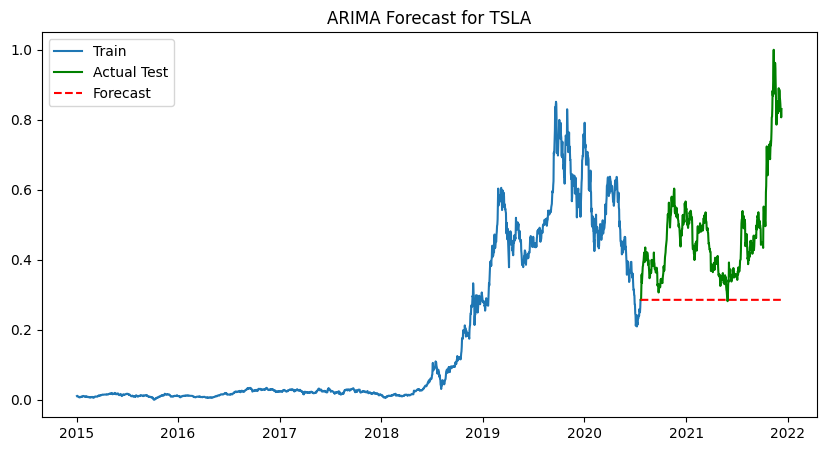

In [33]:
# Plot results
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual Test", color='green')
plt.plot(test.index, forecast, label="Forecast", color='red', linestyle="dashed")
plt.legend()
plt.title(f"ARIMA Forecast for TSLA")
plt.show()

In [34]:
# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2028
Model:                 ARIMA(5, 1, 0)   Log Likelihood                6137.919
Date:                Mon, 03 Mar 2025   AIC                         -12263.838
Time:                        12:30:59   BIC                         -12230.152
Sample:                    01-02-2015   HQIC                        -12251.478
                         - 07-21-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0376      0.012     -3.108      0.002      -0.061      -0.014
ar.L2          0.0154      0.010      1.498      0.134      -0.005       0.036
ar.L3      -1.843e-05      0.013     -0.001      0.9

In [6]:
# Find optimal order automatically
auto_model = auto_arima(train[:500], seasonal=True, m=30, trace=True, stepwise=True)
print(auto_model.summary())

/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=-5744.114, Time=6.90 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=-5753.426, Time=0.14 sec


/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=-5751.742, Time=3.66 sec


/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=-5751.698, Time=5.55 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=-5755.422, Time=0.05 sec


/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[30] intercept   : AIC=-5751.453, Time=5.18 sec


/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[30] intercept   : AIC=-5751.451, Time=1.94 sec


/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[30] intercept   : AIC=-5749.440, Time=4.02 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=-5753.697, Time=0.13 sec


/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=-5753.657, Time=0.68 sec


/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=-5751.712, Time=0.67 sec

Best model:  ARIMA(0,1,0)(0,0,0)[30]          
Total fit time: 28.973 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2878.711
Date:                Tue, 04 Mar 2025   AIC                          -5755.422
Time:                        04:57:49   BIC                          -5751.210
Sample:                    01-02-2015   HQIC                         -5753.769
                         - 05-15-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.698e-07   2.47e-08     23.070      0.000    5.21e

In [7]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

In [8]:
forecast = model_fit.forecast(steps=len(test))
forecast

2020-07-22 05:00:00+00:00    0.284644
2020-07-23 05:00:00+00:00    0.284913
2020-07-24 05:00:00+00:00    0.284803
2020-07-25 05:00:00+00:00    0.284848
2020-07-26 05:00:00+00:00    0.284830
                               ...   
2021-12-06 05:00:00+00:00    0.284835
2021-12-07 05:00:00+00:00    0.284835
2021-12-08 05:00:00+00:00    0.284835
2021-12-09 05:00:00+00:00    0.284835
2021-12-10 05:00:00+00:00    0.284835
Freq: D, Name: predicted_mean, Length: 507, dtype: float64

In [10]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 0.1916
Root Mean Squared Error (RMSE): 0.2366
Mean Absolute Percentage Error (MAPE): 36.14%


In [13]:
# Save the trained model
with open("../models/arima_model.pkl", "wb") as f:
    pickle.dump(model_fit, f)